## 1. Gather and Prepare Data


In [21]:
import os  # Used to check if file already exists
import pandas as pd  # Used to load and manipulate the ratings data
import zipfile  # Used to extract the contents of the zip file

# URL and filename for dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
filename = 'ml-latest-small.zip'

# Check if zip file exists, if not download and extract dataset
if not os.path.exists(filename):
    !wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

# Load and clean ratings data
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.drop_duplicates(inplace=True)
ratings.dropna(inplace=True)

# Convert data to user-item matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Split data into training and test sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings, test_size=0.2)
train_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
test_matrix = test_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

## 2. Choose a Recommendation Algorithm

In [22]:
# Perform matrix factorization using TruncatedSVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
user_factors = svd.fit_transform(train_matrix)
item_factors = svd.components_

## 3. Train the Model

In [23]:
# Initialize matrix factorization and generate user and item factors for training set
svd = TruncatedSVD(n_components=100)
user_factors = svd.fit_transform(train_matrix)
item_factors = svd.components_



## 4. Evaluate the Model

In [24]:
# Predict ratings for test set and calculate MSE
import numpy as np
predicted_ratings = user_factors.dot(item_factors)
test_array = np.array(test_matrix)
mse = mean_squared_error(predicted_ratings[test_array.nonzero()], test_array[test_array.nonzero()])
print(f'Mean Squared Error: {mse}')

# Convert predicted and actual ratings to binary values and calculate classification metrics
threshold = 3.5
predicted_binary = (predicted_ratings > threshold).astype(int)
actual_binary = (test_array > threshold).astype(int)
from sklearn.metrics import mean_squared_error, classification_report
report = classification_report(actual_binary[test_array.nonzero()], predicted_binary[test_array.nonzero()])
print(f'Classification Report:\n{report}')



Mean Squared Error: 12.682481110467355
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.98      0.68     10486
           1       0.42      0.01      0.03      9682

    accuracy                           0.52     20168
   macro avg       0.47      0.50      0.35     20168
weighted avg       0.47      0.52      0.37     20168



## 5. Interpret the Model

Intercept 1.647769668896187
Prediction_local [0.45583819]
Right: 1.0002414082222817
Prediction: 1.00
Explanation:
4717 <= 0.00: -0.20
726 <= 0.00: -0.18
987 <= 0.00: -0.16
2894 <= 0.00: -0.16
214 <= 0.00: -0.12
580 <= 0.00: -0.11
321 <= 0.00: -0.09
299 <= 0.00: -0.07
1187 <= 0.00: -0.07
369 <= 0.00: -0.03


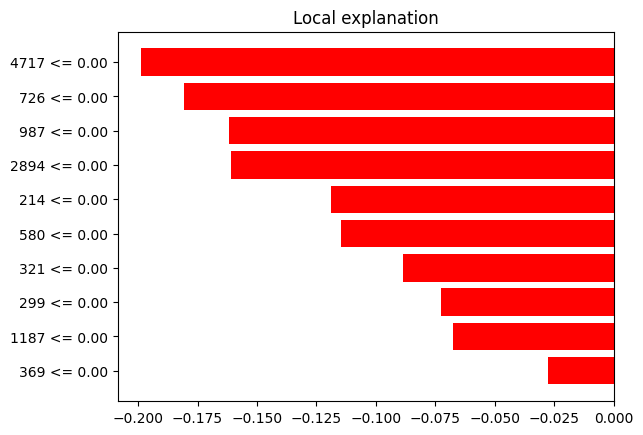

Top features for user 100 and movie 300:
4717 <= 0.00: -0.19862197656771113
726 <= 0.00: -0.18082420789526993
987 <= 0.00: -0.16187081081677296
2894 <= 0.00: -0.16092307300011952
214 <= 0.00: -0.11907109188138243
580 <= 0.00: -0.11450078240543694
321 <= 0.00: -0.08855048280428005
299 <= 0.00: -0.07248359194015923
1187 <= 0.00: -0.06751149277425443
369 <= 0.00: -0.027573969670942087
Recommended movies for user 100 based on analyzed features:


In [26]:
# Make a recommendation for a user and movie and generate an explanation using LIME
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=100)
model = make_pipeline(StandardScaler(), svd, LinearRegression())

# Choose a random user and movie
user_id = 100
movie_id = 300

# Check if the movie_id variable is present in the user_item_matrix dataframe
if movie_id not in user_item_matrix.columns:
    print('Invalid movie ID. Please choose a different movie ID.')
else:
    # Specify the target variable y
    y = user_item_matrix[movie_id]

    # Remove the target variable from the feature matrix X
    X = user_item_matrix.drop(columns=movie_id)

    # Fit the linear regression model
    model.fit(X, y)

    # Make a prediction for the user and movie
    rating = model.predict(np.array([X.loc[user_id].values]))[0]

    # Generate an explanation for the recommendation using LIME
    explainer = LimeTabularExplainer(X.values, feature_names=X.columns, class_names=['rating'], verbose=True, mode='regression')
    explanation = explainer.explain_instance(X.loc[user_id].values, model.predict, num_features=10)

    # Print the prediction and explanation
    print(f'Prediction: {rating:.2f}')
    print('Explanation:')
    for feature, weight in explanation.as_list():
        print(f'{feature}: {weight:.2f}')

    # Visualize the explanation using Matplotlib
    fig = explanation.as_pyplot_figure()
    plt.show()

    # Get top features and provide recommendations based on analyzed features
    top_features = explanation.as_list()
    print(f'Top features for user {user_id} and movie {movie_id}:')
    for feature, weight in top_features:
        print(f'{feature}: {weight}')

    recommended_movies = []
    for feature, weight in top_features:
        if weight > 0:
            recommended_movies.extend(X[X[feature] > 0].index.tolist())
    recommended_movies = list(set(recommended_movies))
    print(f'Recommended movies for user {user_id} based on analyzed features:')
    for movie in recommended_movies:
        if movie != movie_id:
            print(f'{movie}')
